In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Obtain Column Names
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Calculate the date 1 year ago from the last data point in the database
begin_date = session.query(measurement.date).order_by(measurement.date).first()
end_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

print(f"First Recorded Date: {begin_date[0]}. Last Recorded Date: {end_date[0]}.")

First Recorded Date: 2010-01-01. Last Recorded Date: 2017-08-23.


In [13]:
# Perform a query to retrieve the data and precipitation scores
last_date = dt.datetime.strptime(end_date[0], '%Y-%m-%d')
one_year = dt.date(last_date.year -1, last_date.month, last_date.day)

col_select = [measurement.date,measurement.prcp]
time_frame = session.query(*col_select).filter(measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(time_frame, columns=['Date', 'Precipitation'])
precip = precip.dropna(how='any')

# Sort the dataframe by date
precip = precip.sort_values(["Date"], ascending = True)
precip = precip.set_index("Date")
precip.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


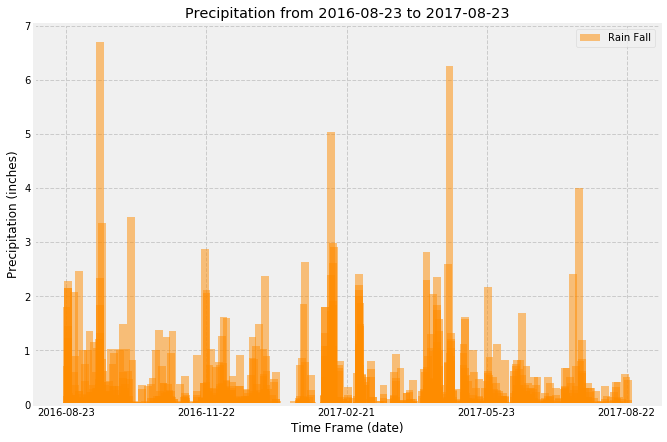

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = precip.index.tolist()
y_axis = precip['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(x_axis, y_axis, width = 5 ,color='darkorange', alpha=0.5, align="center",label='Rain Fall')

major_ticks = np.arange(0,366,91)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {one_year} to {end_date[0]}")
plt.xlabel("Time Frame (date)")
plt.ylabel("Precipitation (inches)")
plt.grid(which='major', axis='both', linestyle='--')
plt.legend()

plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(station.id).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_select = [measurement.station,func.count(measurement.id)]
active_station = session.query(*station_select).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
temp_select = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
temp_station = session.query(*temp_select).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()

print(f"Lowest Temp: {temp_station[0]}, Highest Temp: {temp_station[1]}, Average Temp: {temp_station[2]}")

Lowest Temp: 54.0, Highest Temp: 85.0, Average Temp: 71.66378066378067


In [19]:
# Query the last 12 months of temperature observation data for the station with the highest number of temperature observations and plot the results as a histogram
temp_observe = session.query(measurement.tobs).\
    filter(measurement.station == active_station[0][0]).\
    filter(measurement.date >= one_year).all()
temperature = list(np.ravel(temp_observe))

station_temp_select = [station.station,station.name,station.latitude,station.longitude,station.elevation]
temp_query = session.query(*station_temp_select).all()
station_df = pd.DataFrame(temp_query, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = station_df.loc[station_df["Station"] == active_station[0][0],"Name"].tolist()[0]

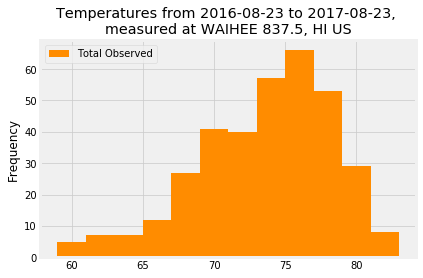

In [20]:
plt.hist(temperature, bins=12,rwidth=1.0,label="Total Observed", color="darkorange")
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperatures from {one_year} to {end_date[0]}, \nmeasured at {station_name}")
plt.legend()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
   
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# Function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
start_date = '2016-05-01'
end_date = '2016-05-07'
temp_result = calc_temps(start_date,end_date)[0]
temp_result

(66.0, 73.81818181818181, 79.0)

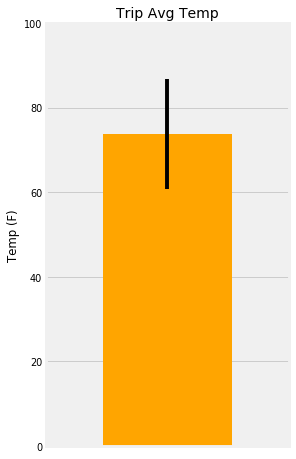

In [23]:
# Plot the results from your previous query as a bar chart. Use "Trip Avg Temp" as your Title. Use the average temperature for the y value. Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [temp_result[1]]
error = [(temp_result[2] - temp_result[0])]

w = 4
h = 8
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates. Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-05-01'
end_date = '2016-05-07'

vacation_sel = [station.station,station.name,station.latitude,station.longitude,station.elevation,func.sum(measurement.prcp)]
vacation_query = session.query(*vacation_sel).\
    filter(station.station == measurement.station).\
    group_by(measurement.station).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    order_by(func.sum(measurement.prcp).desc()).\
    all()
  
per_station = pd.DataFrame(vacation_query, columns=['Station','Name','Latitude','Longitude','Elevation','Rain Total'])
per_station

,Station,Name,Latitude,Longitude,Elevation,Rain Total
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.25
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.54
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.53
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.23
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.92
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.17
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [25]:
# Create a query that will calculate the daily normals (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

Calculate the daily normals for your trip and push each tuple of calculations into a list called normals.



In [26]:
# Set the start and end date of the trip
start_date = '2016-05-01'
end_date = '2016-05-07'

# Use the start and end date to create a range of dates. Stip off the year and save a list of %m-%d strings. Loop through the list of %m-%d strings and calculate the normals for each date
start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')

trip_dates = []
normals = []

while (start <= end):
    trip_dates.append(dt.datetime.strftime(start,'%Y-%m-%d'))
    date = dt.datetime.strftime(start,'%m-%d')
    normals.append(list(np.ravel(daily_normals(date))))
    start = start + dt.timedelta(days = 1)

normals

[[65.0, 72.75925925925925, 79.0],
 [65.0, 73.05084745762711, 79.0],
 [67.0, 73.41071428571429, 84.0],
 [65.0, 73.59649122807018, 78.0],
 [67.0, 73.39655172413794, 79.0],
 [66.0, 73.14035087719299, 80.0],
 [64.0, 71.78846153846153, 79.0]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vacation = pd.DataFrame(normals, columns=['Min Temperature','Average Temperature','Max Temperature'])
vacation['Date'] = trip_dates
vacation = vacation.set_index("Date")
vacation

,Min Temperature,Average Temperature,Max Temperature
Date,,,
2016-05-01,65.0,72.759259,79.0
2016-05-02,65.0,73.050847,79.0
2016-05-03,67.0,73.410714,84.0
2016-05-04,65.0,73.596491,78.0
2016-05-05,67.0,73.396552,79.0
2016-05-06,66.0,73.140351,80.0
2016-05-07,64.0,71.788462,79.0


(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

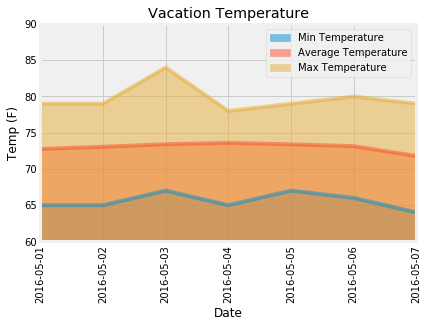

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
vacation.plot.area(stacked=False)
plt.ylim(60,90)
plt.ylabel("Temp (F)")
plt.title("Vacation Temperature")
plt.xticks(rotation=90)